## **Predicting Bike-Sharing Demand Based on Temporal Information and Meteorological Time Series Data**

**Note:** This study utilizes the additional library **tsfresh**, which is not included in the default image. The required version is **0.20.2**. The code includes functionality to automatically detect and install this library.

**word count:** 1997

### **1 Introduction and Literature Review**

In recent years, bike-sharing projects have gradually emerged worldwide, becoming a highlight in urban transportation. These projects aim to address the "last mile" problem in urban travel, enhance connectivity between users and traditional transportation modes (such as subways, buses, etc.), and reduce environmental pollution and traffic congestion issues (DeMaio, 2009) Bike-sharing, as an environmentally friendly and convenient mode of transportation, has been proven to effectively improve the travel experience of urban residents and enhance the efficiency and convenience of urban transportation (Bajracharya et al., 2019).

However, bike-sharing programs still face many challenges, one of which is how to accurately predict bike demand under different conditions in order to better meet the public's travel needs. These factors influencing bike demand include time, date, season, and weather conditions (Eren and Uz, 2020). For example, on a cold and windy Christmas midnight, the demand for bike-sharing may differ significantly from a warm and windless weekday morning.

Current research has explored the impact of various objective factors on bike-sharing behavior (Gallop, Tse and Zhao, 2012). For instance, Sathishkumar et al. used linear regression, support vector machines, and other methods to explore the influence of multidimensional meteorological information (including solar radiation, visibility, etc.) on bike rental usage and developed corresponding models (E, Park and Cho, 2020); Qiao et al. focused on time periods and weather and developed a bike-sharing demand prediction model based on dynamic convolutional neural networks (Qiao et al., 2021); Xu et al. focused on deep learning and developed a long short-term memory neural network to explore the impact of trip length on dockless bike-sharing demand (Xu, Ji and Liu, 2018). However, most studies treat weather and other objective factors as discrete and independent predictor variables, with few considering the impact of these data trends over time on bike demand. However, changes in weather parameters such as temperature, wind speed, and humidity are not abrupt but accumulate as part of a continuous trend. This means that weather conditions do not change suddenly without warning, but rather exhibit signs and trends. Moreover, this trend exhibits a certain degree of periodicity regardless of whether it is measured in hours, days, or seasons (Ivanov, 2002).

Therefore, if time features can be extracted from meteorological data and incorporated as part of the predfactorsiables, establishing a bike-sharing demand prediction model based on various objective conditions will help bike-sharing projects more accurately predict and meet the public's travel needs, thereby improving user experience and alleviating traffic congestion problems.


### **2 Research Question**

Based on existing research and its gaps, the research question proposed in this study is: **How can we accurately predict bike-sharing demand based on temporal information and meteorological time series data?**

### **3 Presentation of Data**

The dataset utilized in this study is sourced from Kaggle, providing London bike-sharing data. Supported by TfL Open Data, this historical dataset spans two years from January 4, 2015, to January 3, 2017, capturing multidimensional data for each hour of every day, totaling 17,520 records.

#### **3.1 The Original Dataset and Their Units**

##### **3.1.1 Temporal Data (Time and Date):**
- Timestamp: Time stamp field used for data grouping, including year, month, day, and hour.
- is_holiday: Boolean field indicating holidays (1) or non-holidays (0).
- is_weekend: Boolean field indicating weekends (1) or weekdays (0).

##### **3.1.2 Meteorological Data:**
- t1: Actual temperature in degrees Celsius.
- t2: "Feels like" temperature in degrees Celsius.
- hum: Relative humidity percentage.
- season: Seasonal category: 0 for spring, 1 for summer, 2 for autumn, and 3 for winter.
- wind_speed: Wind speed in kilometers per hour.
- weather_code: Weather category: 1 for clear or mostly clear, 2 for scattered clouds, 3 for broken clouds, 4 for overcast clouds, 7 for light rain, 10 for heavy rain or thunderstorms, 26 for snowfall, and 94 for freezing fog.

##### **3.1.3 Bike Sharing Data:**
- cnt: Hourly bike usage count represented by the respective timestamp.

#### **3.2 Data Retrieval and Preprocessing**

The dataset used in this study is open data, but it requires registration and login to access for downloading. Therefore, the data was saved on GitHub, and the download was performed using a URL. The following describes the data retrieval process:

In [1]:
## data reading from github repository

import numpy as np
import pandas as pd

url = "https://raw.githubusercontent.com/Yanxulyu/CASA0006-Accessment\
/main/london_merged.csv"
original_data = pd.read_csv(url)

Some preprocessing steps are required on the raw data before it can be used for training. The 'timestamp' column of the data needs to be converted to datetime format, and only the time information needs to be extracted while removing the year-month-day information, which is then saved as the 'hour' column. The code snippet below illustrates the process and provides details of the column names and formats in the final dataframe.

In [2]:
## data cleaning

original_data = original_data.dropna()
original_data["timestamp"] = pd.to_datetime(original_data["timestamp"])

original_data["hour"] = original_data["timestamp"].dt.hour
original_data["hour"] = original_data["hour"].astype("int")

cleaned_data = original_data
cleaned_data_back_up = cleaned_data
print(cleaned_data.dtypes)

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
hour                     int64
dtype: object


### **4 Methodology**

#### **4.1 Time Feature Extraction and Selection**

The variations of actual temperature (t1), perceived temperature (t2), and relative humidity (hum) in the meteorological data tend to exhibit periodic trends in the time series data with a time precision of 1 hour. These trends often manifest cyclic patterns within a day to several days, making them more identifiable in terms of time features compared to other variables, as illustrated in the figure below. Therefore, these three types of data are chosen as the targets for time feature extraction.

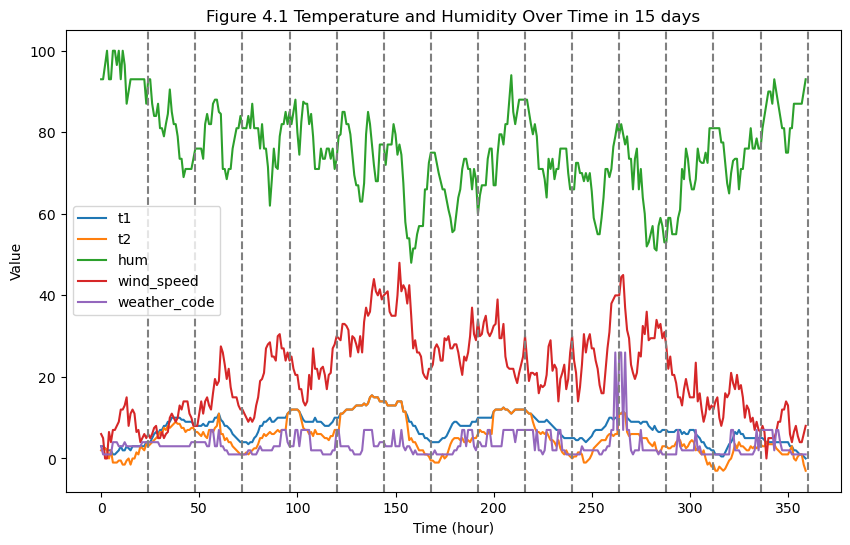

In [3]:
import matplotlib.pyplot as plt

subset = cleaned_data.head(360)
plt.figure(figsize=(10, 6))
plt.plot(subset.index, subset["t1"], label="t1")
plt.plot(subset.index, subset["t2"], label="t2")
plt.plot(subset.index, subset["hum"], label="hum")
plt.plot(subset.index, subset["wind_speed"], label="wind_speed")
plt.plot(subset.index, subset["weather_code"], label="weather_code")
for i in range(1, len(subset.index) // 24 + 1):
    plt.axvline(x=i * 24, color="gray", linestyle="--")
plt.legend()

plt.title("Figure 4.1 Temperature and Humidity Over Time in 15 days")
plt.xlabel("Time (hour)")
plt.ylabel("Value")
plt.show()

During time feature extraction, a function library called "tsfresh" is required, which is not included in the default image. The required version is 0.20.2. This library provides a series of functions for time feature extraction, feature selection, feature calculation, etc. The code snippet below includes a function named "check_installation" to automatically detect whether tsfresh is installed in the current environment and automatically install it if not.

In [4]:
## functions to check and install packages those needed

import importlib.util
import subprocess


def install_package(package):
    subprocess.check_call(["pip", "install", package])


def check_installation(package):
    spec = importlib.util.find_spec(package)
    if spec is None:
        print(f"{package} is not installed. Installing now...")
        install_package(package)
        print(f"{package} has been installed successfully!")
    else:
        print(f"{package} is already installed.")


check_installation("tsfresh")
import tsfresh

tsfresh is already installed.


Time feature extraction and selection were performed separately for actual temperature, “feels like” temperature, and humidity.

For feature extraction, the "feature_extraction" function provided by tsfresh was utilized, which automatically extracts all time features from the data. During the extraction process, a rolling sampling technique was employed with a time window of 24 hours and a step size of 100 hours. This technique was applied to the first 12,000 hours of data, creating subsequences that were then used to extract features. The set of all these subsequences formed the feature matrix X, while the data points at the end of each subsequence were designated as the target vector y for time feature extraction.

For feature selection, the "select_features" function provided by tsfresh was employed. It calculates the correlation table of features contained in the feature matrix X with respect to the target vector y (determined by p-values). Features with poor performance are excluded based on a set threshold, and the remaining features are sorted from best to worst. Finally, the top 2 ranked time features are selected for each variable from these features to serve as part of the independent variables for subsequent model training.

The following outlines the process of time feature extraction and selection for "t1", "t2", and "hum", along with the names of their time features as shown in the output:
- Actual Temperature (t1): t1__abs_energy, t1__root_mean_square
- “feels like” Temperature (t2): t2__sum_values, t2__fft_coefficient__attr_"real"__coeff_0
- Humidity (hum): hum__energy_ratio_by_chunks__num_segments_10__segment_focus_9, hum__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)



In [5]:
## extract and save ideal time-features for t1

import warnings

import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_selection.selection import select_features
from tsfresh.utilities.dataframe_functions import impute

warnings.filterwarnings("ignore")

subsequence_data = cleaned_data.iloc[:12000]

window_size = 24
step = 100

all_features = []
y_values = []
index_counter = 0

for i in range(0, len(subsequence_data) - window_size + 1, step):
    # take subsequences from cleaned data with a size of window_size
    subsequence = subsequence_data["t1"].iloc[i : i + window_size]

    # record the last value of each window as Y
    y = subsequence.iloc[-1]

    # transform the subsequences to dataframe
    # give the rows from the same window a same index
    subsequence_df = pd.DataFrame(
        {"index": [index_counter] * len(subsequence), "t1": subsequence}
    )

    # renew the index counter
    index_counter += 1

    # time-feature extraction
    features = extract_features(
        subsequence_df, column_id="index", column_value="t1", \
        disable_progressbar=True
    )

    all_features.append(features)
    y_values.append(y)

# combine all features to one dataframe, and all y to one series
all_features_df = pd.concat(all_features, ignore_index=True)
y_values_series = pd.Series(y_values, name="y")

# deal with the NaNs
all_features_df = impute(all_features_df)

# select the features
features_filtered = select_features(all_features_df, y_values_series)

# keep 2 of the top best features for the current parameter
selected_feature_categories = features_filtered.columns.tolist()
selected_feature_categories_t1 = selected_feature_categories[0:2]

print("Ideal time-features for real temperature are: ", end="")
for i, item in enumerate(selected_feature_categories_t1):
    if i != 0:
        print(", ", end="")
    print(item, end="")
print()

Ideal time-features for real temperature are: t1__abs_energy, t1__root_mean_square


In [6]:
## extract and save ideal time-features for t2

subsequence_data = cleaned_data.iloc[:12000]

window_size = 24
step = 100

all_features = []
y_values = []
index_counter = 0

for i in range(0, len(subsequence_data) - window_size + 1, step):
    # take subsequences from cleaned data with a size of window_size
    subsequence = subsequence_data["t2"].iloc[i : i + window_size]

    # record the last value of each window as Y
    y = subsequence.iloc[-1]

    # transform the subsequences to dataframe
    # give the rows from the same window a same index
    subsequence_df = pd.DataFrame(
        {"index": [index_counter] * len(subsequence), "t2": subsequence}
    )

    # renew the index counter
    index_counter += 1

    # time-feature extraction
    features = extract_features(
        subsequence_df, column_id="index", column_value="t2", \
        disable_progressbar=True
    )

    all_features.append(features)
    y_values.append(y)

# combine all features to one dataframe, and all y to one series
all_features_df = pd.concat(all_features, ignore_index=True)
y_values_series = pd.Series(y_values, name="y")

# deal with the NaNs
all_features_df = impute(all_features_df)

# select the features
features_filtered = select_features(all_features_df, y_values_series)

# keep 2 of the top best features for the current parameter
selected_feature_categories = features_filtered.columns.tolist()
selected_feature_categories_t2 = selected_feature_categories[0:2]

print("Ideal time-features for 'feels like' temperature are: ", end="")
for i, item in enumerate(selected_feature_categories_t2):
    if i != 0:
        print(", ", end="")
    print(item, end="")
print()

Ideal time-features for 'feels like' temperature are: t2__sum_values, t2__fft_coefficient__attr_"real"__coeff_0


In [7]:
## extract and save ideal time-features for hum

subsequence_data = cleaned_data.iloc[:12000]

window_size = 24
step = 100

all_features = []
y_values = []
index_counter = 0

for i in range(0, len(subsequence_data) - window_size + 1, step):
    # take subsequences from cleaned data with a size of window_size
    subsequence = subsequence_data["hum"].iloc[i : i + window_size]

    # record the last value of each window as Y
    y = subsequence.iloc[-1]

    # transform the subsequences to dataframe
    # give the rows from the same window a same index
    subsequence_df = pd.DataFrame(
        {"index": [index_counter] * len(subsequence), \
         "hum": subsequence}
    )

    # renew the index counter
    index_counter += 1

    # time-feature extraction
    features = extract_features(
        subsequence_df, column_id="index", column_value="hum", \
        disable_progressbar=True
    )

    all_features.append(features)
    y_values.append(y)

# combine all features to one dataframe, and all y to one series
all_features_df = pd.concat(all_features, ignore_index=True)
y_values_series = pd.Series(y_values, name="y")

# deal with the NaNs
all_features_df = impute(all_features_df)

# select the features
features_filtered = select_features(all_features_df, y_values_series)

# keep 2 of the top best features for the current parameter
selected_feature_categories = features_filtered.columns.tolist()
selected_feature_categories_hum = selected_feature_categories[0:2]

print("Ideal time-features for humidity are: ", end="")
for i, item in enumerate(selected_feature_categories_hum):
    if i != 0:
        print(", ", end="")
    print(item, end="")
print()

Ideal time-features for humidity are: hum__energy_ratio_by_chunks__num_segments_10__segment_focus_9, hum__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)


According to a window length of 24 hours, two time features are computed for each row of the original data variables t1, t2, and hum. The resulting values are saved in new columns. Time feature calculation functions utilized in this process are provided by the tsfresh library, with additional parameters automatically presented in the feature names. Since the calculation process requires the previous 24 rows of data for each row, the initial 24 rows in the original dataframe cannot be computed, thus remaining as null values, which are subsequently removed.

In [8]:
## calculate time-features for t1
## and save result to cleaned_data

formula_names = [feature.split("__")[1] for feature in \
                 selected_feature_categories_t1]
for formula_name in formula_names:
    formula_function = getattr(
        tsfresh.feature_extraction.feature_calculators, \
        formula_name
    )
    cleaned_data["t1_" + formula_name] = (
        cleaned_data["t1"].rolling(window=25).apply(\
            lambda x: formula_function(x[:-1]))
    )

In [9]:
## calculate time-features for t2
## and save result to cleaned_data

# t2__sum_values
formula_names = [feature.split("__")[1] for feature in \
                 selected_feature_categories_t2]

formula_name = formula_names[0]
formula_function = getattr(\
    tsfresh.feature_extraction.feature_calculators, formula_name)
cleaned_data["t2_sum_values"] = (
    cleaned_data["t2"].rolling(\
        window=25).apply(lambda x: formula_function(x[:-1]))
)

# t2__fft_coefficient__attr_"real"__coeff_0
formula_name = formula_names[1]
param = [{"coeff": 0, "attr": "real"}]
formula_function = getattr(\
    tsfresh.feature_extraction.feature_calculators, formula_name)

cleaned_data["t2_fft_coefficient"] = np.nan

window_size = 25

for i in range(len(cleaned_data["t2"]) - window_size + 1):
    window_data = cleaned_data["t2"].iloc[i : i + window_size]
    window_result = formula_function(window_data, param)

    cleaned_data["t2_fft_coefficient"].iloc[i + window_size - 1]\
    = next(window_result)[
        1
    ]

In [10]:
## calculate time-features for hum
## and save result to cleaned_data

formula_names = [feature.split("__")[1] for feature in \
                 selected_feature_categories_hum]

# hum__energy_ratio_by_chunks__num_segments_10__segment_focus_9
formula_name = formula_names[0]
param = [{"num_segments": 10, "segment_focus": 9}]
formula_function = getattr(\
    tsfresh.feature_extraction.feature_calculators, formula_name)

cleaned_data["hum_energy_ratio_by_chunks"] = np.nan

window_size = 25

for i in range(len(cleaned_data["t2"]) - window_size + 1):
    window_data = cleaned_data["t2"].iloc[i : i + window_size]
    window_result = formula_function(window_data, param)

    cleaned_data["hum_energy_ratio_by_chunks"].iloc[i + window_size - 1]\
    = ((window_result)[0])[1]

# hum__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)
formula_name = formula_names[1]
param = [{"coeff": 1, "w": 2, "widths": [2, 5, 10, 20]}]
formula_function = getattr(tsfresh.feature_extraction.feature_calculators, \
                           formula_name)

cleaned_data["hum_cwt_coefficients"] = np.nan

for i in range(len(cleaned_data["t2"]) - window_size + 1):
    window_data = cleaned_data["t2"].iloc[i : i + window_size]
    window_result = formula_function(window_data, param)

    cleaned_data["hum_cwt_coefficients"].iloc[i + window_size - 1] = next(
        window_result
    )[1]

The dataframe with the newly added variables is shown in the code box below:

In [11]:
## delete NaNs and restore to a new dataframe

full_data = cleaned_data.dropna()
full_data.drop("timestamp", axis=1, inplace=True)
pd.set_option("display.max_columns", 30)
print(full_data.head())

    cnt   t1   t2   hum  wind_speed  weather_code  is_holiday  is_weekend  \
24   83  4.0  3.0  93.0         6.0           4.0         0.0         0.0   
25   67  4.0  3.5  93.0         5.0           4.0         0.0         0.0   
26   32  5.0  4.0  87.0         6.0           4.0         0.0         0.0   
27   22  6.0  4.5  84.0         7.5           4.0         0.0         0.0   
28   38  6.5  5.0  84.0         8.0           4.0         0.0         0.0   

    season  hour  t1_abs_energy  t1_root_mean_square  t2_sum_values  \
24     3.0     0         159.75             2.579971           15.5   
25     3.0     1         166.75             2.635890           16.5   
26     3.0     2         173.75             2.690647           17.5   
27     3.0     3         192.50             2.832108           19.0   
28     3.0     4         224.50             3.058458           21.5   

    t2_fft_coefficient  hum_energy_ratio_by_chunks  hum_cwt_coefficients  
24                18.5             

#### **4.2 Collinearity Analysis**

Conducting collinearity analysis for all independent variables. According to the correlation matrix heatmap generated below, it can be observed that there is significant collinearity among the six variables, namely t1, t2, and their four corresponding time features, while no apparent collinearity exists among the other variables.

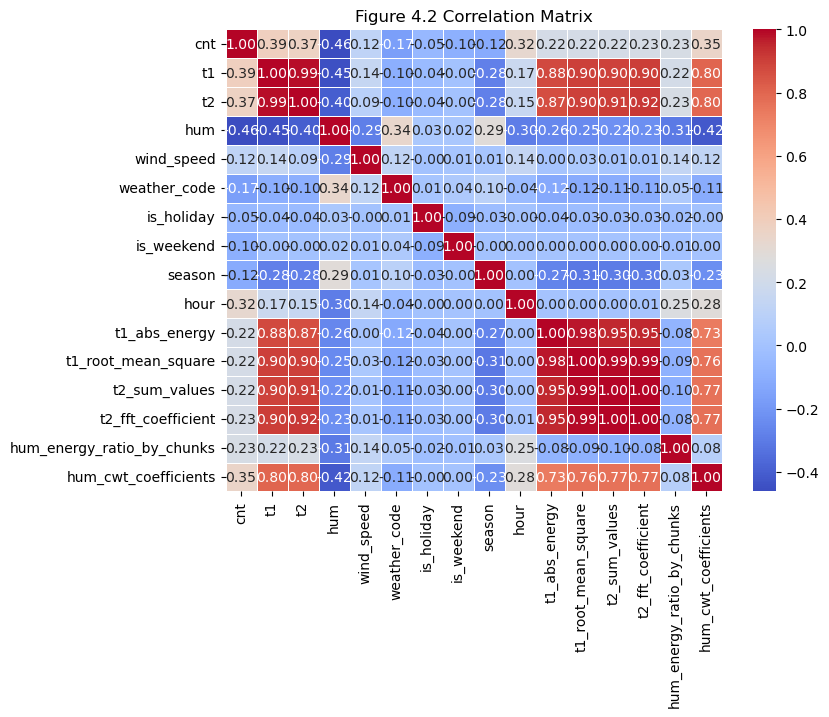

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

corr_matrix = full_data.corr()

# 绘制相关矩阵的热力图
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", \
            linewidths=0.5)
plt.title("Figure 4.2 Correlation Matrix")
plt.show()

Collinearity is a serious issue that may lead to unstable predictions and reduced model interpretability (Mason and Perreault, 1991). Therefore, PCA is employed to integrate the six variables. The Explained Variance Ratios of the first two principal components are 9.5 and 5.3, respectively. It is decided to retain these two principal components as new variables. As the selected variables are all temperature-related, they are named "temperature1" and "temperature2". 

The updated dataframe and correlation matrix heatmap are presented below:

In [13]:
## use PCA to deal with X columns that correlated to each other
## t1, t2 and their time features, 6 columns in total

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

temperature_columns = [
    "t1",
    "t2",
    "t1_abs_energy",
    "t1_root_mean_square",
    "t2_sum_values",
    "t2_fft_coefficient",
]
temperature_data = full_data[temperature_columns]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(temperature_data)

pca = PCA()
pca.fit(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)

n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)


principal_df = pd.DataFrame(
    data=principal_components,
    columns=[f"temperature{i+1}" for i in range(n_components)],
)

df_with_pcs = pd.concat(
    [full_data.drop(columns=temperature_columns), \
     principal_df], axis=1
)

print(df_with_pcs.head())

Explained variance ratio: [9.46300165e-01 4.09440752e-02 1.06623147e-02 1.60447365e-03
 4.88971822e-04 5.29620813e-32]
     cnt   hum  wind_speed  weather_code  is_holiday  is_weekend  season  \
24  83.0  93.0         6.0           4.0         0.0         0.0     3.0   
25  67.0  93.0         5.0           4.0         0.0         0.0     3.0   
26  32.0  87.0         6.0           4.0         0.0         0.0     3.0   
27  22.0  84.0         7.5           4.0         0.0         0.0     3.0   
28  38.0  84.0         8.0           4.0         0.0         0.0     3.0   

    hour  hum_energy_ratio_by_chunks  hum_cwt_coefficients  temperature1  \
24   0.0                    0.269841              2.431086     -1.994852   
25   1.0                    0.244253              2.968518     -1.959805   
26   2.0                    0.291990              2.775937     -1.959350   
27   3.0                    0.327314              2.222698     -1.967431   
28   4.0                    0.343454        

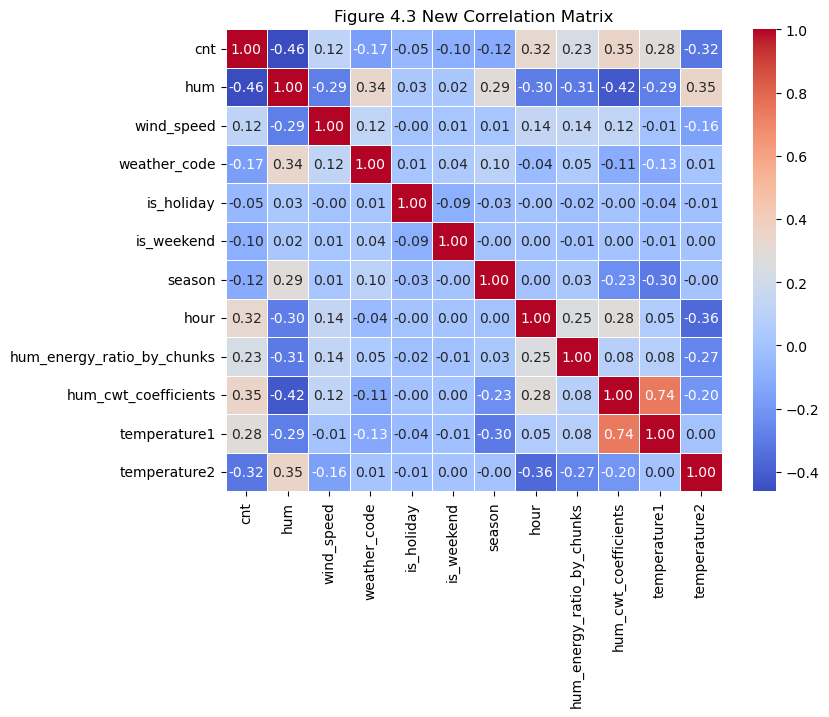

In [14]:
## output new correlation matrix with updated data

corr_matrix = df_with_pcs.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", \
            fmt=".2f", linewidths=0.5)
plt.title("Figure 4.3 New Correlation Matrix")
plt.show()

#### **4.3 Model Training Using Random Forest**

The final set of independent variables in the dataset includes: humidity (hum), wind speed (wind_speed), weather category (weather_code), holiday indicator (is_holiday), weekend indicator (is_weekend), season category (season), hour of the day (hour), humidity time features (hum_energy_ratio_by_chunks and hum_cwt_coefficients), and two temperature variables (temperature1 and temperature2).

Using these variables, a random forest method is employed to train a predictive model for bike usage (cnt). Random forest is a machine learning technique based on multiple decision trees. Its advantages include the ability to handle datasets with a large number of predictor variables, efficiency, high accuracy of model predictions (Speiser et al., 2019), and suitability for scenarios with large datasets, such as the one in this study, thereby reducing the risks of underfitting and overfitting.



##### **4.3.1 Time Series Data Model Training (Experimental Group)**

A random forest model was trained for predicting bike-sharing demand using the data with added time features extracted from meteorological data as independent variables. The R-squared and MSE values are available in the output section.


In [15]:
## random forest (with time-features)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

df_with_pcs = df_with_pcs.dropna()
X = df_with_pcs.drop(columns=["cnt"])  # independent variables (X)
y = df_with_pcs["cnt"]  # dependent cariables (y)

random_value = 13

# divide into train group and test group
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_value
)


rf_model = RandomForestRegressor(random_state=random_value)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-square(R2):", r2)

Mean Squared Error: 50052.75658529073
R-square(R2): 0.9573178716404198


##### **4.3.2 Static Model Training (Control Group)**

A random forest model was trained for predicting bike-sharing demand using the original data as independent variables. The R-squared and MSE values are available in the output section. This section employs static data, treating the independent variables at each timestamp as discrete and independent states, serving as a control.


In [16]:
## random forest (regular training without time-features)

cleaned_data_back_up = cleaned_data_back_up.dropna()
cleaned_data_back_up.drop("timestamp", axis=1, inplace=True)
X = cleaned_data_back_up.drop(columns=["cnt"])
y = cleaned_data_back_up["cnt"]

random_value = 3

# divide into train group and test group
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_value
)


rf_model = RandomForestRegressor(random_state=random_value)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-square(R2):", r2)

Mean Squared Error: 73127.63384381829
R-square(R2): 0.9394166292815618


### **5 Results and Discussion**

Based on the results of the predictive model in the experimental group, it can be observed that the R² value of the model trained using specific data time features as part of the independent variables remains stable around 0.96, while the MSE value stabilizes around 50000.

In contrast, a traditional static random forest model trained using raw data is used for comparison. It is evident that in terms of R², the traditional model stabilizes around 0.93, with MSE values stabilizing around 70000.

Upon self-comparison longitudinally, it is evident that the predictive model for bike-sharing demand trained using the random forest method combined with the extraction of time series features as independent variables exhibits higher accuracy, which aligns with expectations.

Comparison with the static method:
- Regarding R², while the improvement of the method used in the study compared to the traditional method is relatively small, it is consistent and observable, approximately a stable 3% increase. This result is presumed to be due to the large volume and excellent quality of the data selected for this study, as well as precise variable selection, leading to the traditional static model training method already producing a good fit. It is challenging for the new model method to significantly improve the R² of the model based on the use of this data.
- In terms of MSE, the method used in the study exhibits a significantly and consistently reduced value compared to the traditional method, with a reduction rate stabilizing around 29%. This indicates a clear and substantial improvement in the effectiveness and accuracy of the model predictions compared to the traditional method.

### **6 Conclusion**

The study integrates time series analysis methods, including time feature extraction, and utilizes random forest methodology based on temporal and meteorological data to train a highly accurate predictive model for London's bike-sharing demand. The model accuracy meets expectations, with an R² stabilizing above 0.95 and MSE stabilizing around 50000. Compared to not using time series analysis methods, there is an improvement of 3% and a decrease of 29% in R² and MSE, respectively, indicating a significant enhancement in model accuracy.

With this approach, we can better predict bike-sharing demand based on various objective conditions, thereby enhancing user experience, optimizing urban transportation networks, and reducing pollution and traffic congestion.


### **References**

Bajracharya, L. et al. (2019) ‘A Study on Cost-Effective and Eco-friendly Bicycle Sharing System for Developing Countries’, in K.J. Kim and N. Baek (eds) Information Science and Applications 2018. Singapore: Springer, pp. 523–531. Available at: https://doi.org/10.1007/978-981-13-1056-0_52.

DeMaio, P. (2009) ‘Bike-sharing: History, Impacts, Models of Provision, and Future’, Journal of Public Transportation, 12(4), pp. 41–56. Available at: https://doi.org/10.5038/2375-0901.12.4.3.

E, S.V., Park, J. and Cho, Y. (2020) ‘Using data mining techniques for bike sharing demand prediction in metropolitan city’, Computer Communications, 153, pp. 353–366. Available at: https://doi.org/10.1016/j.comcom.2020.02.007.

Eren, E. and Uz, V.E. (2020) ‘A review on bike-sharing: The factors affecting bike-sharing demand’, Sustainable Cities and Society, 54, p. 101882. Available at: https://doi.org/10.1016/j.scs.2019.101882.

Gallop, C., Tse, C. and Zhao, J. (2012) ‘A seasonal autoregressive model of Vancouver bicycle traffic using weather variables’, in. Transportation research board 91st annual meeting.

Ivanov, V.V. (2002) ‘Periodic weather and climate variations’, Physics-Uspekhi, 45(7), p. 719. Available at: https://doi.org/10.1070/PU2002v045n07ABEH000948.

Mason, C.H. and Perreault, W.D. (1991) ‘Collinearity, Power, and Interpretation of Multiple Regression Analysis’, Journal of Marketing Research, 28(3), pp. 268–280. Available at: https://doi.org/10.1177/002224379102800302.

Qiao, S. et al. (2021) ‘A Dynamic Convolutional Neural Network Based Shared-Bike Demand Forecasting Model’, ACM Transactions on Intelligent Systems and Technology, 12(6), p. 70:1-70:24. Available at: https://doi.org/10.1145/3447988.

Speiser, J.L. et al. (2019) ‘A comparison of random forest variable selection methods for classification prediction modeling’, Expert Systems with Applications, 134, pp. 93–101. Available at: https://doi.org/10.1016/j.eswa.2019.05.028.

Xu, C., Ji, J. and Liu, P. (2018) ‘The station-free sharing bike demand forecasting with a deep learning approach and large-scale datasets’, Transportation Research Part C: Emerging Technologies, 95, pp. 47–60. Available at: https://doi.org/10.1016/j.trc.2018.07.013.
